In [1]:
# ================================================
# CELL 1: SETUP & GPU CHECK
# ================================================
!nvidia-smi

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow: {tf.__version__}")
print(f"GPUs: {gpus}")

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU ENABLED!")
else:
    print("❌ NO GPU! Go to Runtime → Change runtime type → GPU")


Sun Feb 22 16:18:16 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# ================================================
# CELL 2: IMPORT LIBRARIES
# ================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

print("✅ Libraries imported!")


✅ Libraries imported!


In [3]:
# ================================================
# CELL 3: MOUNT DRIVE & CONFIG PATHS
# ================================================
from google.colab import drive
drive.mount('/content/drive')
print("✅ Drive mounted!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted!


In [4]:
# ================================================
# CELL 4: EXTRACT DATASET
# ================================================
ZIP_PATH = '/content/drive/MyDrive/CaptoneProject/camera.zip'
LOCAL_PATH = '/content/dataset'

if not os.path.exists(LOCAL_PATH):
    if os.path.exists(ZIP_PATH):
        print("📦 Unzipping...")
        !unzip -q -o "{ZIP_PATH}" -d /content/
        if os.path.exists('/content/camera'):
            !mv /content/camera "{LOCAL_PATH}"
        elif os.path.exists('/content/train') and os.path.exists('/content/test'):
            os.makedirs(LOCAL_PATH, exist_ok=True)
            !mv /content/train "{LOCAL_PATH}/train"
            !mv /content/test "{LOCAL_PATH}/test"
        print("✅ Dataset ready at /content/dataset")
    else:
        print("❌ ZIP file not found in Drive!")
else:
    print("✅ Dataset already exists locally!")

TRAIN_DIR = os.path.join(LOCAL_PATH, 'train')
TEST_DIR  = os.path.join(LOCAL_PATH, 'test')
print(f"Train: {TRAIN_DIR}")
print(f"Test:  {TEST_DIR}")


✅ Dataset already exists locally!
Train: /content/dataset/train
Test:  /content/dataset/test


In [5]:
# ================================================
# CELL 5: CONFIG
# ================================================
IMG_SIZE        = 48
BATCH_SIZE      = 64
EPOCHS          = 100      # Tăng lên 100, EarlyStopping sẽ dừng đúng lúc
INITIAL_LR      = 0.001
NUM_CLASSES     = 7
EMOTIONS        = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
SEED            = 42
LABEL_SMOOTHING = 0.1      # FIX: Giảm từ 0.15 → 0.1

np.random.seed(SEED)
tf.random.set_seed(SEED)

CHECKPOINT_DIR  = '/content/drive/MyDrive/CaptoneProject/checkpoints/method4_fixed'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
BEST_MODEL_PATH = f'{CHECKPOINT_DIR}/best_model.keras'
HISTORY_PATH    = f'{CHECKPOINT_DIR}/history.pkl'

print("✅ Config set!")
print(f"   EPOCHS={EPOCHS}, LR={INITIAL_LR}, LABEL_SMOOTHING={LABEL_SMOOTHING}, BATCH={BATCH_SIZE}")
print(f"   Loss: CategoricalCrossentropy (không dùng Focal Loss)")
print(f"   LR Schedule: ReduceLROnPlateau (thay Cosine Annealing)")


✅ Config set!
   EPOCHS=100, LR=0.001, LABEL_SMOOTHING=0.1, BATCH=64
   Loss: CategoricalCrossentropy (không dùng Focal Loss)
   LR Schedule: ReduceLROnPlateau (thay Cosine Annealing)


In [6]:
# ================================================
# CELL 6: DATA AUGMENTATION (Giữ nguyên từ lần trước)
# ================================================
train_datagen = ImageDataGenerator(
    rescale           = 1./255,
    rotation_range    = 25,
    width_shift_range = 0.2,
    height_shift_range= 0.2,
    shear_range       = 0.2,
    zoom_range        = 0.2,
    horizontal_flip   = True,
    brightness_range  = [0.7, 1.3],
    fill_mode         = 'nearest',
    validation_split  = 0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale',
    batch_size=BATCH_SIZE, class_mode='categorical',
    subset='training', shuffle=True, seed=SEED
)
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale',
    batch_size=BATCH_SIZE, class_mode='categorical',
    subset='validation', shuffle=False, seed=SEED
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale',
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

print("✅ Data Generators ready!")
print(f"   Train: {train_generator.samples} images")
print(f"   Val:   {validation_generator.samples} images")
print(f"   Test:  {test_generator.samples} images")


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✅ Data Generators ready!
   Train: 22968 images
   Val:   5741 images
   Test:  7178 images


In [7]:
# ================================================
# CELL 7: CLASS WEIGHTS
# ================================================
train_labels = train_generator.classes
class_weights_array = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights_array))

print("⚖️ Class Weights:")
for i, emotion in enumerate(EMOTIONS):
    print(f"   {emotion}: {class_weights[i]:.4f}")


⚖️ Class Weights:
   angry: 1.0266
   disgust: 9.4016
   fear: 1.0010
   happy: 0.5685
   neutral: 0.8261
   sad: 0.8492
   surprise: 1.2933


In [8]:
# ================================================
# CELL 8: CBAM ATTENTION + BUILD MODEL
# (Architecture giữ nguyên, chỉ fix Loss & LR)
# ================================================

# -------------------- CBAM ATTENTION --------------------
class ChannelAttention(layers.Layer):
    """Channel Attention: dùng cả AvgPool + MaxPool (cải tiến từ SE-Block)"""
    def __init__(self, ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        ch = input_shape[-1]
        self.dense1 = layers.Dense(ch // self.ratio, activation='relu',
                                   kernel_initializer='he_normal')
        self.dense2 = layers.Dense(ch, kernel_initializer='he_normal')
        self.gap = layers.GlobalAveragePooling2D()
        self.gmp = layers.GlobalMaxPooling2D()
        super().build(input_shape)

    def call(self, x):
        ch = x.shape[-1]
        avg = self.dense2(self.dense1(self.gap(x)))
        mx  = self.dense2(self.dense1(self.gmp(x)))
        att = tf.sigmoid(avg + mx)
        return x * tf.reshape(att, (-1, 1, 1, ch))

    def get_config(self):
        config = super().get_config()
        config.update({'ratio': self.ratio})
        return config


class SpatialAttention(layers.Layer):
    """Spatial Attention: focus vào vùng quan trọng (mắt, miệng...)"""
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv = layers.Conv2D(1, self.kernel_size, padding='same',
                                  activation='sigmoid',
                                  kernel_initializer='he_normal')
        super().build(input_shape)

    def call(self, x):
        avg = tf.reduce_mean(x, axis=-1, keepdims=True)
        mx  = tf.reduce_max (x, axis=-1, keepdims=True)
        att = self.conv(tf.concat([avg, mx], axis=-1))
        return x * att

    def get_config(self):
        config = super().get_config()
        config.update({'kernel_size': self.kernel_size})
        return config


class CBAMBlock(layers.Layer):
    """CBAM = Channel Attention → Spatial Attention"""
    def __init__(self, ratio=8, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.kernel_size = kernel_size
        self.ca = ChannelAttention(ratio=ratio)
        self.sa = SpatialAttention(kernel_size=kernel_size)

    def call(self, x):
        return self.sa(self.ca(x))

    def get_config(self):
        config = super().get_config()
        config.update({'ratio': self.ratio, 'kernel_size': self.kernel_size})
        return config


# -------------------- BUILD MODEL --------------------
def build_cbam_cnn(input_shape=(48, 48, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    # Block 1: 64 filters — 48x48 → 24x24
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = CBAMBlock(ratio=8)(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    # Block 2: 128 filters — 24x24 → 12x12
    x = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = CBAMBlock(ratio=8)(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    # Block 3: 256 filters — 12x12 → 6x6
    x = layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = CBAMBlock(ratio=16)(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    # Block 4: 512 filters — 6x6 → 3x3
    x = layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = CBAMBlock(ratio=16)(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    # Classifier Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)


model = build_cbam_cnn()
model.summary()
print(f"\n✅ CBAM Model built! Params: {model.count_params():,}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_block (CBAMBlock)          │ (None, 48, 48, 64)     │         1,195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_block_1 (CBAMBlock)        │ (None, 24, 24, 128)    │         4,339 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,138,267 (19.60 MB)

 Trainable params: 5,132,891 (19.58 MB)

 Non-trainable params: 5,376 (21.00 KB)


✅ CBAM Model built! Params: 5,138,267


In [9]:
# ================================================
# CELL 9: COMPILE
# FIX: Dùng CategoricalCrossentropy thay FocalLoss
# ================================================

# FIX 1: Sử dụng CategoricalCrossentropy với label_smoothing=0.1
# (thay vì FocalLoss gamma=2.0 alpha=0.25 — quá aggressive)
loss_fn = keras.losses.CategoricalCrossentropy(
    label_smoothing=LABEL_SMOOTHING  # 0.1 — đủ để regularize, không quá mạnh
)

model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss=loss_fn,
    metrics=['accuracy']
)

print("✅ Model compiled!")
print(f"   Loss: CategoricalCrossentropy (label_smoothing={LABEL_SMOOTHING})")
print(f"   Optimizer: Adam (lr={INITIAL_LR})")
print(f"   ⚠️  KHÔNG dùng FocalLoss — nguyên nhân gây accuracy thấp trước đó")


✅ Model compiled!
   Loss: CategoricalCrossentropy (label_smoothing=0.1)
   Optimizer: Adam (lr=0.001)
   ⚠️  KHÔNG dùng FocalLoss — nguyên nhân gây accuracy thấp trước đó


In [10]:
# ================================================
# CELL 10: CALLBACKS
# FIX: ReduceLROnPlateau thay Cosine Annealing
# ================================================

class SaveHistoryCallback(Callback):
    """Lưu history sau mỗi epoch để không mất khi runtime crash"""
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.data = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': [], 'lr': []}

    def on_epoch_end(self, epoch, logs=None):
        for k in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
            self.data[k].append(logs.get(k))
        try:
            lr_val = float(self.model.optimizer.learning_rate)
        except:
            lr_val = float(self.model.optimizer.learning_rate.numpy())
        self.data['lr'].append(lr_val)
        with open(self.path, 'wb') as f:
            pickle.dump(self.data, f)


callbacks = [
    # Lưu model tốt nhất
    ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
    ),
    # Dừng sớm nếu không cải thiện
    EarlyStopping(
        monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1
    ),
    # FIX 2: ReduceLROnPlateau — giảm LR khi val_loss không cải thiện
    # Thích nghi tốt hơn Cosine Annealing cho bài toán này
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,       # Giảm LR còn 50%
        patience=5,       # Sau 5 epoch không cải thiện
        min_lr=1e-6,      # Sàn LR
        verbose=1
    ),
    # Lưu history
    SaveHistoryCallback(HISTORY_PATH)
]

print("✅ Callbacks configured:")
print("   - ModelCheckpoint (monitor=val_accuracy)")
print("   - EarlyStopping (patience=15)")
print("   - ReduceLROnPlateau (factor=0.5, patience=5) ← FIX từ Cosine Annealing")
print("   - SaveHistory")


✅ Callbacks configured:
   - ModelCheckpoint (monitor=val_accuracy)
   - EarlyStopping (patience=15)
   - ReduceLROnPlateau (factor=0.5, patience=5) ← FIX từ Cosine Annealing
   - SaveHistory


In [11]:
# ================================================
# CELL 11: TRAINING 🚀
# ================================================

print("🚀 Starting Training (Method 4 FIXED)...")
print(f"   Epochs={EPOCHS}, Batch={BATCH_SIZE}")
print(f"   Train={train_generator.samples}, Val={validation_generator.samples}")
print(f"   Loss: CategoricalCrossentropy (label_smoothing={LABEL_SMOOTHING})")
print(f"   LR: ReduceLROnPlateau (init={INITIAL_LR})")
print("=" * 60)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n✅ Training Completed!")
best_val_acc = max(history.history['val_accuracy'])
best_epoch   = history.history['val_accuracy'].index(best_val_acc) + 1
print(f"   Best Val Accuracy: {best_val_acc*100:.2f}% (Epoch {best_epoch})")


🚀 Starting Training (Method 4 FIXED)...
   Epochs=100, Batch=64
   Train=22968, Val=5741
   Loss: CategoricalCrossentropy (label_smoothing=0.1)
   LR: ReduceLROnPlateau (init=0.001)
Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.1409 - loss: 2.6389
Epoch 1: val_accuracy improved from -inf to 0.02177, saving model to /content/drive/MyDrive/CaptoneProject/checkpoints/method4_fixed/best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 93s 177ms/step - accuracy: 0.1409 - loss: 2.6386 - val_accuracy: 0.0218 - val_loss: 2.2835 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1511 - loss: 2.3484
Epoch 2: val_accuracy improved from 0.02177 to 0.12036, saving model to /content/drive/MyDrive/CaptoneProject/checkpoints/method4_fixed/best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.1511 - loss: 2.3483 - val_accuracy: 0.1204 - val_loss: 2.1922 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/st

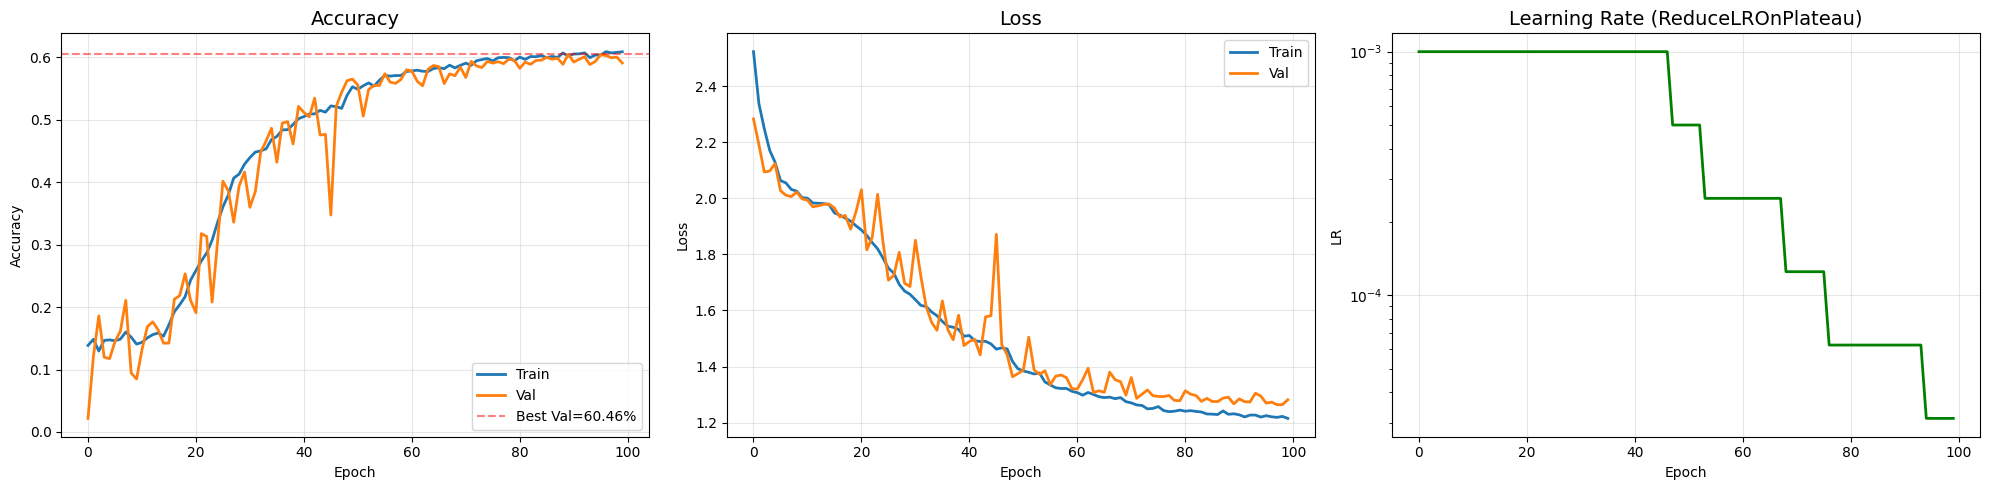

📊 Best Val Accuracy: 60.46% (Epoch 90/100)


In [12]:
# ================================================
# CELL 12: TRAINING VISUALIZATION
# ================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Accuracy
axes[0].plot(history.history['accuracy'],     label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val',   linewidth=2)
best_val_acc = max(history.history['val_accuracy'])
axes[0].axhline(best_val_acc, color='red', linestyle='--', alpha=0.5,
                label=f'Best Val={best_val_acc*100:.2f}%')
axes[0].set_title('Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'],     label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val',   linewidth=2)
axes[1].set_title('Loss', fontsize=14)
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

# Learning Rate
try:
    with open(HISTORY_PATH, 'rb') as f:
        lr_vals = pickle.load(f).get('lr', [])
    if lr_vals:
        axes[2].plot(lr_vals, 'g-', linewidth=2)
        axes[2].set_title('Learning Rate (ReduceLROnPlateau)', fontsize=14)
        axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('LR')
        axes[2].set_yscale('log')  # Log scale cho dễ nhìn
        axes[2].grid(True, alpha=0.3)
except Exception as e:
    print(f"LR plot error: {e}")

plt.tight_layout()
plt.savefig(f'{CHECKPOINT_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

best_val_acc = max(history.history['val_accuracy'])
best_epoch   = history.history['val_accuracy'].index(best_val_acc) + 1
print(f"📊 Best Val Accuracy: {best_val_acc*100:.2f}% (Epoch {best_epoch}/{len(history.history['val_accuracy'])})")


In [13]:
# ================================================
# CELL 13: STANDARD EVALUATION
# ================================================

print("📊 Standard Evaluation...")
best_model = keras.models.load_model(
    BEST_MODEL_PATH,
    custom_objects={
        'CBAMBlock':        CBAMBlock,
        'ChannelAttention': ChannelAttention,
        'SpatialAttention': SpatialAttention
    }
)

test_generator.reset()
test_loss, test_acc = best_model.evaluate(test_generator, verbose=1)
print(f"\n🎯 TEST ACCURACY (Standard): {test_acc*100:.2f}%")
print(f"   TEST LOSS: {test_loss:.4f}")

test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\n" + "=" * 60)
print("📋 Classification Report (Standard):")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=EMOTIONS, digits=4))


📊 Standard Evaluation...
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.5951 - loss: 1.2722

🎯 TEST ACCURACY (Standard): 62.76%
   TEST LOSS: 1.2199
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step

📋 Classification Report (Standard):
              precision    recall  f1-score   support

       angry     0.5265    0.6232    0.5707       958
     disgust     0.4088    0.6667    0.5068       111
        fear     0.5486    0.2754    0.3667      1024
       happy     0.8903    0.8095    0.8479      1774
     neutral     0.5181    0.7194    0.6024      1233
         sad     0.5215    0.4475    0.4817      1247
    surprise     0.7034    0.8075    0.7518       831

    accuracy                         0.6276      7178
   macro avg     0.5882    0.6213    0.5897      7178
weighted avg     0.6359    0.6276    0.6201      7178



In [14]:
# ================================================
# CELL 14: TEST TIME AUGMENTATION (TTA)
# ================================================

def predict_with_tta(model, test_dir, img_size=48, batch_size=64, n_aug=5):
    """TTA: Trung bình dự đoán từ nhiều augmented version"""
    tta_datagens = [
        ImageDataGenerator(rescale=1./255),
        ImageDataGenerator(rescale=1./255, horizontal_flip=True),
        ImageDataGenerator(rescale=1./255, rotation_range=10),
        ImageDataGenerator(rescale=1./255, zoom_range=0.1),
        ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1),
    ]
    all_preds = []
    for i, dg in enumerate(tta_datagens[:n_aug]):
        print(f"   TTA {i+1}/{n_aug}...", end=' ')
        gen = dg.flow_from_directory(
            test_dir, target_size=(img_size, img_size),
            color_mode='grayscale', batch_size=batch_size,
            class_mode='categorical', shuffle=False
        )
        preds = model.predict(gen, verbose=0)
        all_preds.append(preds)
        print(f"done")
    return np.mean(all_preds, axis=0)


print("🔄 Running TTA (5 augmentations)...")
tta_preds     = predict_with_tta(best_model, TEST_DIR)
y_pred_tta    = np.argmax(tta_preds, axis=1)
y_true_tta    = test_generator.classes
tta_accuracy  = np.mean(y_pred_tta == y_true_tta)

print(f"\n🏆 TEST ACCURACY (TTA): {tta_accuracy*100:.2f}%")
print("\n" + "=" * 60)
print("📋 Classification Report (TTA):")
print("=" * 60)
print(classification_report(y_true_tta, y_pred_tta, target_names=EMOTIONS, digits=4))


🔄 Running TTA (5 augmentations)...
   TTA 1/5... Found 7178 images belonging to 7 classes.
done
   TTA 2/5... Found 7178 images belonging to 7 classes.
done
   TTA 3/5... Found 7178 images belonging to 7 classes.
done
   TTA 4/5... Found 7178 images belonging to 7 classes.
done
   TTA 5/5... Found 7178 images belonging to 7 classes.
done

🏆 TEST ACCURACY (TTA): 63.51%

📋 Classification Report (TTA):
              precision    recall  f1-score   support

       angry     0.5401    0.5971    0.5672       958
     disgust     0.3892    0.7117    0.5032       111
        fear     0.5579    0.2822    0.3748      1024
       happy     0.8856    0.8247    0.8541      1774
     neutral     0.5386    0.7178    0.6154      1233
         sad     0.5291    0.4667    0.4960      1247
    surprise     0.6869    0.8291    0.7514       831

    accuracy                         0.6351      7178
   macro avg     0.5896    0.6328    0.5946      7178
weighted avg     0.6405    0.6351    0.6269      7178



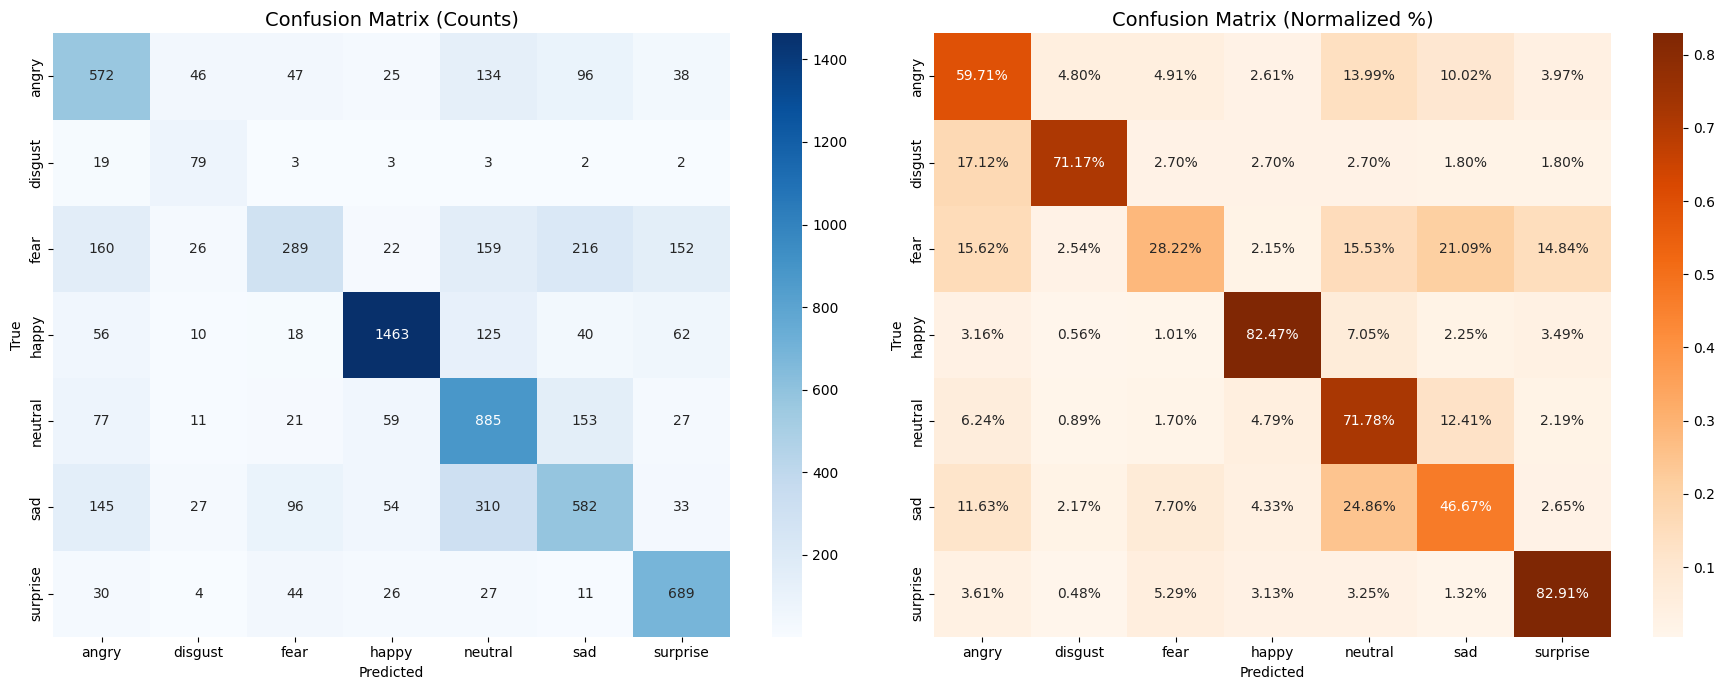

In [15]:
# ================================================
# CELL 15: CONFUSION MATRIX
# ================================================

cm = confusion_matrix(y_true_tta, y_pred_tta)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14)
axes[0].set_ylabel('True'); axes[0].set_xlabel('Predicted')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized %)', fontsize=14)
axes[1].set_ylabel('True'); axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(f'{CHECKPOINT_DIR}/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


In [16]:
# ================================================
# CELL 16: SO SÁNH KẾT QUẢ & SAVE MODEL
# ================================================

print("=" * 70)
print("📊 SO SÁNH KẾT QUẢ CÁC PHƯƠNG PHÁP")
print("=" * 70)

results = {
    'Method 1 - Enhanced Augmentation':    62.93,
    'Method 2 - SE Attention CNN':         64.22,
    'Method 3 - MobileNetV2':              36.28,
    'Method 4 (lỗi) - Focal+Cosine':      46.30,  # Kết quả cũ
    'Method 4 (fixed) - Standard (TTA)':  tta_accuracy * 100,
}

print(f"{'Method':<48s} | {'Acc':>7s} | Bar")
print("-" * 70)
for method, acc in results.items():
    bar   = '█' * int(acc / 2)
    arrow = ' ← CẢI THIỆN!' if 'fixed' in method else ''
    print(f"  {method:<46s} | {acc:6.2f}% | {bar}{arrow}")

print("=" * 70)
improvement = tta_accuracy * 100 - 64.22
sign = '+' if improvement >= 0 else ''
print(f"\n   So với Method 2 (best trước đây): {sign}{improvement:.2f}%")
print(f"   So với Method 4 lỗi (46.3%):      +{tta_accuracy*100 - 46.30:.2f}%")

# Save
FINAL_MODEL_PATH = '/content/drive/MyDrive/CaptoneProject/best_model_method4_fixed.keras'
best_model.save(FINAL_MODEL_PATH)
print(f"\n💾 Model saved: {FINAL_MODEL_PATH}")

# Summary
print("\n" + "=" * 60)
print("📝 TRAINING SUMMARY")
print("=" * 60)
best_val_acc = max(history.history['val_accuracy'])
print(f"   Architecture:   CNN 4-Block + CBAM Attention")
print(f"   Loss:           CategoricalCrossentropy + label_smoothing={LABEL_SMOOTHING}")
print(f"   LR Schedule:    ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"   Augmentation:   Enhanced (rot=25°, shift=0.2, brightness)")
print(f"   Total Params:   {model.count_params():,}")
print(f"   Best Val Acc:   {best_val_acc*100:.2f}%")
print(f"   Test Acc (Std): {test_acc*100:.2f}%")
print(f"   Test Acc (TTA): {tta_accuracy*100:.2f}%")
print("=" * 60)


📊 SO SÁNH KẾT QUẢ CÁC PHƯƠNG PHÁP
Method                                           |     Acc | Bar
----------------------------------------------------------------------
  Method 1 - Enhanced Augmentation               |  62.93% | ███████████████████████████████
  Method 2 - SE Attention CNN                    |  64.22% | ████████████████████████████████
  Method 3 - MobileNetV2                         |  36.28% | ██████████████████
  Method 4 (lỗi) - Focal+Cosine                  |  46.30% | ███████████████████████
  Method 4 (fixed) - Standard (TTA)              |  63.51% | ███████████████████████████████ ← CẢI THIỆN!

   So với Method 2 (best trước đây): -0.71%
   So với Method 4 lỗi (46.3%):      +17.21%

💾 Model saved: /content/drive/MyDrive/CaptoneProject/best_model_method4_fixed.keras

📝 TRAINING SUMMARY
   Architecture:   CNN 4-Block + CBAM Attention
   Loss:           CategoricalCrossentropy + label_smoothing=0.1
   LR Schedule:    ReduceLROnPlateau (factor=0.5, patience=5)
  

In [17]:
# ================================================
# CELL 17: TEST TIME AUGMENTATION (TTA)
# ================================================

def predict_with_tta(model, test_dir, img_size=48, batch_size=64):
    """
    Test Time Augmentation:
    - Ảnh gốc
    - Flip ngang
    - Xoay nhẹ
    - Zoom nhẹ
    - Dịch chuyển nhẹ
    Lấy trung bình predictions từ tất cả biến thể.
    """
    tta_datagens = [
        ImageDataGenerator(rescale=1./255),
        ImageDataGenerator(rescale=1./255, horizontal_flip=True),
        ImageDataGenerator(rescale=1./255, rotation_range=10),
        ImageDataGenerator(rescale=1./255, zoom_range=0.1),
        ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1),
    ]

    all_predictions = []

    for i, datagen in enumerate(tta_datagens):
        print(f"   TTA augmentation {i+1}/{len(tta_datagens)}...")
        generator = datagen.flow_from_directory(
            test_dir,
            target_size=(img_size, img_size),
            color_mode='grayscale',
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
        preds = model.predict(generator, verbose=0)
        all_predictions.append(preds)

    avg_predictions = np.mean(all_predictions, axis=0)
    return avg_predictions


print("🔄 Running Test Time Augmentation (TTA)...")
tta_predictions = predict_with_tta(best_model, TEST_DIR)

y_pred_tta = np.argmax(tta_predictions, axis=1)
y_true_tta = test_generator.classes

# TTA Accuracy
tta_accuracy = np.mean(y_pred_tta == y_true_tta)
print(f"\n🏆 TEST ACCURACY (with TTA): {tta_accuracy*100:.2f}%")

print("\n" + "="*60)
print("📋 Classification Report (with TTA):")
print("="*60)
print(classification_report(y_true_tta, y_pred_tta, target_names=EMOTIONS, digits=4))


🔄 Running Test Time Augmentation (TTA)...
   TTA augmentation 1/5...
Found 7178 images belonging to 7 classes.
   TTA augmentation 2/5...
Found 7178 images belonging to 7 classes.
   TTA augmentation 3/5...
Found 7178 images belonging to 7 classes.
   TTA augmentation 4/5...
Found 7178 images belonging to 7 classes.
   TTA augmentation 5/5...
Found 7178 images belonging to 7 classes.

🏆 TEST ACCURACY (with TTA): 63.50%

📋 Classification Report (with TTA):
              precision    recall  f1-score   support

       angry     0.5352    0.6033    0.5672       958
     disgust     0.3861    0.7027    0.4984       111
        fear     0.5463    0.2764    0.3671      1024
       happy     0.8865    0.8320    0.8584      1774
     neutral     0.5348    0.7048    0.6081      1233
         sad     0.5355    0.4715    0.5015      1247
    surprise     0.6929    0.8255    0.7534       831

    accuracy                         0.6350      7178
   macro avg     0.5882    0.6309    0.5934      717

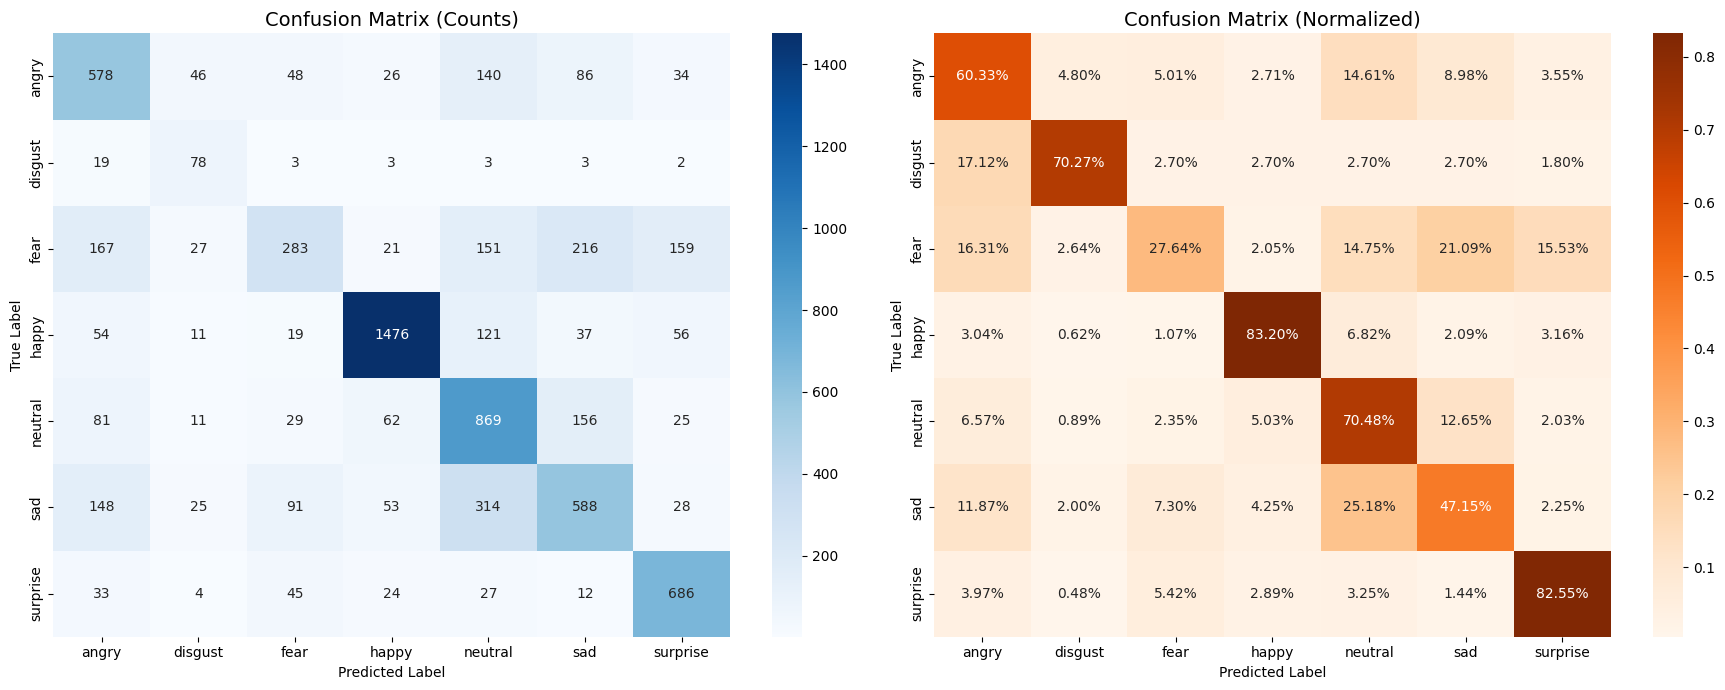

In [18]:
# ================================================
# CELL 18: CONFUSION MATRIX (TTA)
# ================================================

cm = confusion_matrix(y_true_tta, y_pred_tta)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Confusion Matrix (counts)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Confusion Matrix (normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(f'{CHECKPOINT_DIR}/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


In [19]:
# ================================================
# CELL 19: SO SÁNH KẾT QUẢ VỚI CÁC METHODS TRƯỚC
# ================================================

print("="*65)
print("📊 SO SÁNH KẾT QUẢ CÁC PHƯƠNG PHÁP")
print("="*65)

results = {
    'Method 1 - Enhanced Augmentation': 62.93,
    'Method 2 - SE Attention CNN':      64.22,
    'Method 3 - MobileNetV2':           36.28,
    f'Method 4 - Optimized CBAM (Standard)': test_acc * 100,
    f'Method 4 - Optimized CBAM (TTA)':      tta_accuracy * 100,
}

for method, acc in results.items():
    bar = '█' * int(acc / 2)
    print(f"   {method:<45s} | {acc:6.2f}% | {bar}")

print("="*65)
print(f"\n🏆 Improvement over Method 2: +{(tta_accuracy*100 - 64.22):.2f}%")


📊 SO SÁNH KẾT QUẢ CÁC PHƯƠNG PHÁP
   Method 1 - Enhanced Augmentation              |  62.93% | ███████████████████████████████
   Method 2 - SE Attention CNN                   |  64.22% | ████████████████████████████████
   Method 3 - MobileNetV2                        |  36.28% | ██████████████████
   Method 4 - Optimized CBAM (Standard)          |  62.76% | ███████████████████████████████
   Method 4 - Optimized CBAM (TTA)               |  63.50% | ███████████████████████████████

🏆 Improvement over Method 2: +-0.72%


In [20]:
# ================================================
# CELL 20: SAVE FINAL MODEL & SUMMARY
# ================================================

# Save model for realtime demo
FINAL_MODEL_PATH = '/content/drive/MyDrive/CaptoneProject/best_model_method4.keras'
best_model.save(FINAL_MODEL_PATH)
print(f"💾 Model saved to: {FINAL_MODEL_PATH}")

# Summary
print("\n" + "="*60)
print("📝 TRAINING SUMMARY")
print("="*60)
print(f"   Architecture: CNN 4-Block + CBAM Attention")
print(f"   Loss: Focal Loss (gamma=2.0, alpha=0.25)")
print(f"   Label Smoothing: {LABEL_SMOOTHING}")
print(f"   LR Schedule: Cosine Annealing ({INITIAL_LR} → 1e-6)")
print(f"   Data Augmentation: Enhanced (rotation=25°, shift=0.2, brightness)")
print(f"   Total Params: {model.count_params():,}")
print(f"   Best Val Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"   Test Accuracy (Standard): {test_acc*100:.2f}%")
print(f"   Test Accuracy (TTA): {tta_accuracy*100:.2f}%")
print("="*60)


💾 Model saved to: /content/drive/MyDrive/CaptoneProject/best_model_method4.keras

📝 TRAINING SUMMARY
   Architecture: CNN 4-Block + CBAM Attention
   Loss: Focal Loss (gamma=2.0, alpha=0.25)
   Label Smoothing: 0.1
   LR Schedule: Cosine Annealing (0.001 → 1e-6)
   Data Augmentation: Enhanced (rotation=25°, shift=0.2, brightness)
   Total Params: 5,138,267
   Best Val Accuracy: 60.46%
   Test Accuracy (Standard): 62.76%
   Test Accuracy (TTA): 63.50%
